 
variational_autoencoder.ipynb 
 
See http://arxiv.org/abs/1312.6114 and http://www.1-4-5.net/~dmm/ml/vae.pdf for an 
introduction to VAEs. 
 
Inspiration from https://arxiv.org/abs/1312.6114 and https://jmetzen.github.io/2015-11-27/vae.html 

David Meyer 
<dmm@1-4-5.net>
Thu Oct  6 10:07:30 2016 


In [1]:
# 
# 
#       Get the libraries we need 
from   tensorflow.examples.tutorials.mnist import input_data 
from   sklearn.metrics                     import mean_squared_error 
from   datetime                            import timedelta 
import tensorflow                          as     tf 
import numpy                               as     np 
import matplotlib.pyplot                   as     plt 
import time 
import math 
import os
#                                                                               
#       turn off some warnings                                                  
#                                                                               
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# 
# 
#       global parameters 
# 
DEBUG               = 1 
training_epochs     = 1         # use 1 for debugging 
display_step        = 1         # ditto
# 
# 
#       initialize random number generators 
# 
np.random.seed(0) 
tf.set_random_seed(0) 
# 
#       get MNIST. Store it on ./MNIST_data 
# 
mnist     = input_data.read_data_sets('MNIST_data', one_hot=True) 
n_samples = mnist.train.num_examples 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Here we're using Xavier initialization of weights and biases. See https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow on how to do 
xavier init in tensorflow. See http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf for details.


In [2]:
def xavier_init(fan_in, fan_out, constant=1):  
    low  = -constant * np.sqrt(6.0/(fan_in + fan_out))  
    high =  constant * np.sqrt(6.0/(fan_in + fan_out)) 
    return tf.random_uniform((fan_in, 
                              fan_out), 
                              minval=low, 
                              maxval=high, 
                              dtype=tf.float32)

Build a VariationalAutoencoder class so we can instantiate it various ways. 

Based on D. Kingma and Welling, M., "Auto-Encoding Variational Bayes", https://arxiv.org/abs/1312.6114. 

The trained model can be used to reconstruct unseen input, to generate new samples, and to map 
inputs to the latent space. 

Again, inspiration from https://jmetzen.github.io/2015-11-27/vae.html.


In [3]:
class VariationalAutoencoder(object): 
    def __init__(self, 
                 network_architecture, 
                 transfer_fct=tf.nn.softplus,  
                 learning_rate=0.001, 
                 batch_size=100): 
        self.network_architecture = network_architecture 
        self.transfer_fct         = transfer_fct 
        self.learning_rate        = learning_rate 
        self.batch_size           = batch_size 
         
        self.x = tf.placeholder(tf.float32,     # input placeholder 
                                [None, network_architecture["n_input"]]) 
        self._create_network()                   
# 
#       Define loss function based variational upper-bound 
#       and corresponding optimizer  
# 
        self._elbo() 
# 
#       set up tensorflow 
# 
        init = tf.global_variables_initializer() # init variables 
        self.sess = tf.InteractiveSession()      
        self.sess.run(init)                      # launch the session 
# 
#       create autoencoder network 
#     
    def _create_network(self): 
# 
#       First initialize weights and biases 
# 
        network_weights = self._initialize_weights(**self.network_architecture) 
# 
#       f(x;\phi) returns the mean and variance of a Gaussian that can be 
#       used to sample the hidden variables z. That is, 
#       z ~ q_{\phi}(z|x) = q(z;f(x,\phi)) \approx N(z| f(x,\phi)), See 
#       e.g., http://www.1-4-5.net/~dmm/ml/vae.pdf 
# 
        self.z_mean, self.z_log_sigma_sq = self._f(network_weights["weights_f"],network_weights["biases_f"]) 
# 
# 
#       draw one sample z from N(0,1) 
# 
        n_z = self.network_architecture["n_z"] 
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32) 
# 
#       compute z = mu + sigma*epsilon (reparameterization trick) 
# 
        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps)) 
# 
#       The generator outputs the mean of the Bernoulli distribution 
#       of the reconstructed input 
# 
        self.x_reconstr_mean = self._g(network_weights["weights_g"],network_weights["biases_g"]) 

        # 
#       housekeeping/weights and biases data structures 
# 
#       store these in the dictionary "dict" 
# 
# 
    def _initialize_weights(self, 
                            n_hidden_f_1, 
                            n_hidden_f_2,  
                            n_hidden_g_1, 
                            n_hidden_g_2,  
                            n_input, n_z): 
        all_weights = dict() 
        all_weights['weights_f'] = { 
            'h1': tf.Variable(xavier_init(n_input, n_hidden_f_1)), 
            'h2': tf.Variable(xavier_init(n_hidden_f_1, n_hidden_f_2)), 
            'out_mean': tf.Variable(xavier_init(n_hidden_f_2, n_z)), 
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_f_2, n_z))} 
        all_weights['biases_f'] = { 
            'b1': tf.Variable(tf.zeros([n_hidden_f_1], dtype=tf.float32)), 
            'b2': tf.Variable(tf.zeros([n_hidden_f_2], dtype=tf.float32)), 
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)), 
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))} 
        all_weights['weights_g'] = { 
            'h1': tf.Variable(xavier_init(n_z, n_hidden_g_1)), 
            'h2': tf.Variable(xavier_init(n_hidden_g_1, n_hidden_g_2)), 
            'out_mean': tf.Variable(xavier_init(n_hidden_g_2, n_input)), 
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_g_2, n_input))} 
        all_weights['biases_g'] = { 
            'b1': tf.Variable(tf.zeros([n_hidden_g_1], dtype=tf.float32)), 
            'b2': tf.Variable(tf.zeros([n_hidden_g_2], dtype=tf.float32)), 
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)), 
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))} 
        return all_weights 
    
# 
#       _f 
# 
#       Probabilistic encoder f(z;\theta), also sometimes called a 
#       "recognition network". f(.) maps its inputs X onto a normal 
#       distribution in latent space. Returns the parameters of that 
#       normal distribution, namely N(z_mean, z_log_sigma_sq) (mod the log, 
#       see Appendex F.1 of https://arxiv.org/pdf/1312.6114v10.pdf. 
# 
#       Note self.transfer_fct = tf.nn.softplus (log(exp(features)+1), 
#       a smooth approximation to the rectifier function (f(x) = max(0,x)) 
# 
    def _f(self, weights, biases): 
        layer_1        = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),biases['b1']))  
        layer_2        = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),biases['b2']))  
        z_mean         = tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean']) 
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']),biases['out_log_sigma']) 
        return (z_mean, z_log_sigma_sq) 

# 
#       _g 
# 
#       Probabilistic decoder (decoder network), which maps points 
#       in latent space onto a Bernoulli distribution in data space. 
#       Again, transformation is parametrized and can be learned. 
# 
    def _g(self, weights, biases): 
        layer_1         = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),biases['b1']))  
        layer_2         = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))  
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])) 
        return x_reconstr_mean 
    
#
#
#
#       _elbo
# 
#       The approach taken by VAE's s is to introduce an inference 
#       model q_{\phi|(z|x) that learns to  approximate the 
#       intractable posterior p_{\theta}(z|x) by optimizing the 
#       variational lower bound or ELBO (see 
#       https://arxiv.org/pdf/1601.00670.pdf for details). 
# 
#       In this case, the ELBO (loss) is composed of two terms: 
# 
#       (i).    The reconstruction loss (the negative log probability  
#               of the input under the reconstructed Bernoulli distribution  
#               induced by the decoder in the data space). 
# 
#               See appendix C.1 of https://arxiv.org/pdf/1312.6114v10.pdf 
# 
#               Note: 1e-10 is added to avoid trying to evaluate  log(0.0) 
# 
#       (ii).   The latent loss, which is defined as the Kullback Leibler 
#               Divergence between the distribution in latent space induced 
#               by the encoder on the data and some prior. 
# 
#               The KL term is essentially a regularizer which pulls the 
#               estimated posterior q_{\phi}(z|x) toward the prior p(z). 
# 
#               See appendix B of https://arxiv.org/pdf/1312.6114v10.pdf 
# 
# 
    def _elbo(self): 
        reconstr_loss  = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) 
                                        + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 
                                        1) 
        latent_loss    = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq  
                                              - tf.square(self.z_mean)  
                                              - tf.exp(self.z_log_sigma_sq), 
                                              1) 
        self.cost      = tf.reduce_mean(reconstr_loss + latent_loss)  
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) 
         
# 
#       Train on minibatch if desired 
# 
    def partial_fit(self, X): 
        opt, cost = self.sess.run((self.optimizer, self.cost),feed_dict={self.x: X}) 
        return cost 
     
# 
#       transform(.) maps to mean of distribution, Note here 
#       that we could abandon the encoder pathway f(z;\phi}) and 
#       simply sample from N(0,1) 
# 
    def transform(self, X): 
        """Transform data by mapping it into the latent space.""" 
        return self.sess.run(self.z_mean, feed_dict={self.x: X}) 
     
# 
#       generate(.) 
# 
#       Generate samples from the latent space.  
#         
#       Here if z_mu is not None, then the data for this point in 
#       latent space is generated. Otherwise, z_mu is drawn from prior 
#       in latent space (i.e., N(0,1)) 
 
    def generate(self, z_mu=None): 
        if z_mu is None: 
            z_mu = np.random.normal(size=self.network_architecture["n_z"]) 
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.z: z_mu}) 
#     
#       reconstruct(.) 
# 
#       Reconstruct X 
# 
# 
    def reconstruct(self, X): 
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x: X})
 

In [4]:
# 
#       Now, train the vae in mini-batches 
# 
# 
def train(network_architecture, learning_rate=0.001,batch_size=100, training_epochs=10, display_step=5): 
    vae = VariationalAutoencoder(network_architecture,learning_rate=learning_rate,batch_size=batch_size) 
    for epoch in range(training_epochs):                       # training cycle 
        avg_cost    = 0.0
        total_batch = int(n_samples / batch_size) 
        for i in range(total_batch):                           # loop over all batches 
            batch_xs, _ = mnist.train.next_batch(batch_size) 
            cost        = vae.partial_fit(batch_xs)            # fit training data 
            avg_cost   += cost / n_samples * batch_size        # compute average loss 
 
        if epoch % display_step == 0:                         
            print "Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost) 
    return vae 

Now, build an instance. First build a network architecture (network_architecture), then train the network on MNIST. Put a cell below this to hold training_epochs so we can experiment with it.

In [5]:
training_epochs=1
display_step=1

In [6]:
# 
#       Train a VAE on MNIST. First, specify the network  
# 
network_architecture = dict(n_hidden_f_1=500,       # 1st layer encoder neurons 
                            n_hidden_f_2=500,       # 2nd layer encoder neurons 
                            n_hidden_g_1=500,       # 1st layer decoder neurons 
                            n_hidden_g_2=500,       # 2nd layer decoder neurons 
                            n_input=784,            # MNIST (img shape: 28*28) 
                            n_z=20)                 # dimension of latent space (I used 100 on my autoencoder)
# 
#       now train the network 
# 
if (DEBUG): 
        print "Training for {} epoch(s)".format(training_epochs) 
        print "display_step = {}".format(display_step)
        
vae           = train(network_architecture,training_epochs=training_epochs,display_step=display_step) 
x_sample      = mnist.test.next_batch(100)[0] 
x_reconstruct = vae.reconstruct(x_sample) 

Training for 1 epoch(s)
display_step = 1
Epoch: 0001 cost = 174.409492576


Calculate the reconstruction probability. See e.g., algorithm 4 of http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf 

In [7]:
reconstruction_error = mean_squared_error(x_sample, x_reconstruct) 
print "reconstruction error = {}".format(reconstruction_error) 

reconstruction error = 0.0335734635592


Take a simple look at what we built

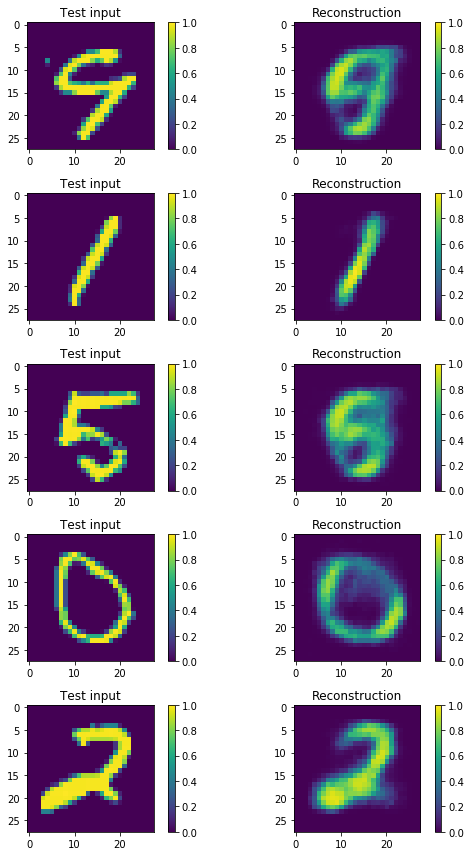

In [8]:
plt.figure(figsize=(8, 12)) 
for i in range(5): 
    plt.subplot(5, 2, 2*i + 1) 
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1) 
    plt.title("Test input") 
    plt.colorbar() 
    plt.subplot(5, 2, 2*i + 2) 
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1) 
    plt.title("Reconstruction") 
    plt.colorbar() 
plt.tight_layout() 
plt.show() 